In [1]:
# visualize model outputs on randomly generated test data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from munch import Munch

import models
import utils

In [3]:
oil_change_data_root = '../data/OilChangeDataset'
ann_file = '20171103_OilChange.json'
camera_name = 'floating_kinect1'
mode = 'object'
#mode = 'mask'
config_path = 'pretrained/floating_kinect1_{}/config.yml'.format(mode)
blender_path = '/usr/local/bin/blender'

In [4]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

/home/huo/virtuallist/py36/lib/python3.6/site-packages/munch/__init__.py:505: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return munchify(yaml.load(*args, **kwargs))


In [5]:
camera_parameters = utils.get_camera_parameters(oil_change_data_root, ann_file, camera_name)
model_paths = utils.get_model_paths(oil_change_data_root, ann_file, cfg.data.objects)
pose_renderers = [
    utils.PoseRenderer(blender_path, camera_parameters, model_path, mode)
    for model_path in model_paths
]

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [6]:
model = models.Model(cfg.arch)
model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True
checkpoint = torch.load(cfg.training.resume)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("=> loaded checkpoint '{}' (epoch {})".format(cfg.training.resume, checkpoint['epoch']))

=> loaded checkpoint 'pretrained/floating_kinect1_object/checkpoint_00002100.pth.tar' (epoch 2100)


In [7]:
transform = transforms.ToTensor()

In [8]:
def visualize_batch(model, pose_renderers, input, object_index):
    object_index = object_index.cuda(non_blocking=True)
    position, orientation = model(input, object_index)

    image = input.numpy()
    image = image.squeeze(1) if image.shape[1] == 1 else image.transpose((0, 2, 3, 1))
    object_index = object_index.cpu().numpy()
    position = position.cpu().numpy()
    orientation = orientation.cpu().numpy()

    for i in range(input.size(0)):
        _, axes = plt.subplots(1, 2, figsize=(2 * 4, 4))
        rendered_pose = pose_renderers[object_index[i]].render(position[i], orientation[i])
        axes[0].imshow(image[i], cmap='gray' if image.ndim == 3 else None)
        axes[1].imshow(rendered_pose, cmap='gray' if image.ndim == 3 else None)
        plt.show()

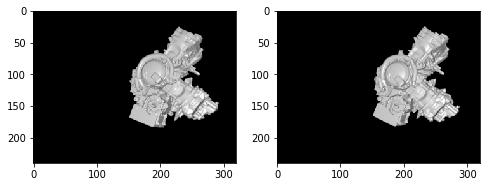

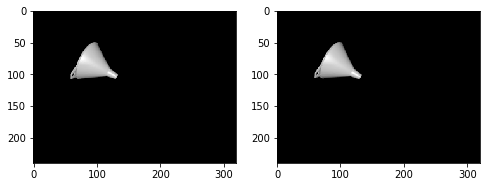

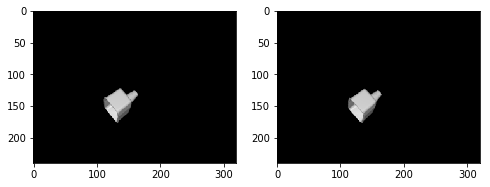

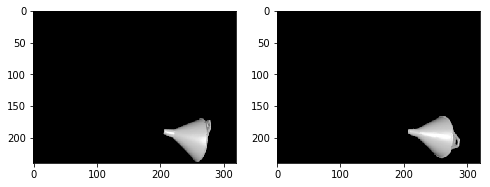

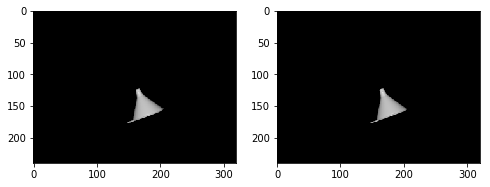

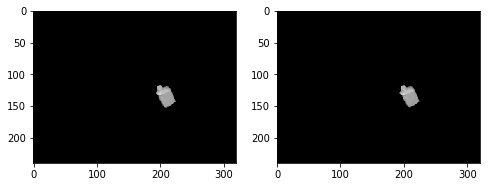

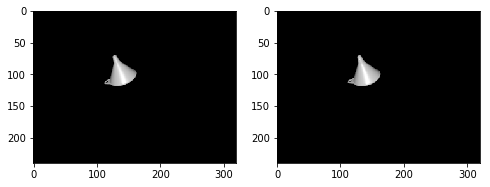

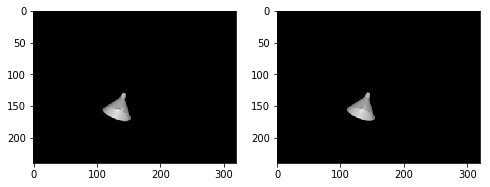

In [9]:
# randomly generate poses, render poses as input images, then display (input image, rendered pose estimate)
num_examples = 8
object_scales = [0.3, 0.3, 0.2, 0.7, 0.2]

with torch.no_grad():
    for _ in range(num_examples):
        # randomly sample an object class with random pose
        object_index = np.random.randint(len(cfg.data.objects))
        object_scale = object_scales[object_index]
        position_mean = [0, 0, object_scale * 3]
        position_cov = np.diag(np.square(object_scale * 0.5 * np.array([1.5, 0.8, 2])))
        position = np.random.multivariate_normal(position_mean, position_cov)
        orientation = np.random.randn(4)
        orientation = np.divide(orientation, np.linalg.norm(orientation, axis=0, keepdims=True))
        rendered_pose = pose_renderers[object_index].render(position, orientation)
        input = transform(rendered_pose).unsqueeze(0)
        object_index = torch.LongTensor([object_index])
        visualize_batch(model, pose_renderers, input, object_index)